In [ ]:
!pip install pyswarms

In [ ]:
pip install tensorflow keras-tuner scikit-learn pandas numpy matplotlib

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [38]:
df = pd.read_csv("/kaggle/input/cloud-computing-performance-metrics/vmCloud_data.csv")

df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,2023-01-25 09:10:54,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,2023-01-26 04:46:34,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,2023-01-13 23:39:47,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2023-02-09 11:45:49,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,2023-06-14 08:27:26,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting


In [39]:
df.shape

(2000000, 12)

In [40]:
# Handle missing values
df = df.fillna(method='ffill')


df.shape

<ipython-input-40-1c3ca3487565>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


(2000000, 12)

In [41]:
def clean_data(df):
    # Drop irrelevant columns
    df = df.drop(columns=['vm_id', 'timestamp'])
    
    # Handle missing values
    # Numerical columns: impute with median
    num_cols = df.select_dtypes(include=np.number).columns
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    
    # Categorical columns: impute with mode (excluding target column)
    cat_cols = df.select_dtypes(include='object').columns.drop('task_status')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    return df

cleaned_df = clean_data(df)
cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,71.518937,29.901883,164.775973,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,71.518937,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,54.488318,88.100960,203.674847,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,42.365480,88.100960,203.674847,359.451537,3361.0,55.307992,0.351907,compute,medium,waiting


In [59]:
scaler = StandardScaler()
numerical_columns = cleaned_df.select_dtypes(include=[np.number]).columns
cleaned_df[numerical_columns] = scaler.fit_transform(cleaned_df[numerical_columns])
cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,0.169442,1.004010,-1.160942,0.260706,0.874592,0.669916,0.184175,network,medium,waiting
6,-0.215845,-0.954949,-0.245324,0.157970,1.387868,0.351499,-0.135904,compute,high,completed
9,-0.403406,-1.163505,0.969151,0.917638,-0.698161,-0.271814,-1.252230,io,medium,running
10,1.010887,-1.630568,1.476837,-0.529774,1.261715,0.197300,0.967227,compute,medium,completed
12,0.236059,-1.651950,0.770904,-0.738856,1.658195,1.028639,1.538766,io,medium,waiting


In [42]:
# Convert target column to binary classification
def convert_target_column(df):
    df['task_status'] = df['task_status'].apply(lambda x: 0 if x in ['completed'] else 1)
    return df

cleaned_df = convert_target_column(cleaned_df)
cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,1
1,71.518937,29.901883,164.775973,362.273569,5348.0,41.396040,0.349856,io,high,0
2,71.518937,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,0
3,54.488318,88.100960,203.674847,195.639954,5876.0,16.456670,0.529511,compute,high,0
4,42.365480,88.100960,203.674847,359.451537,3361.0,55.307992,0.351907,compute,medium,1


In [107]:
cleaned_df = cleaned_df.drop(columns=['task_type','task_priority'])
cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_status
0,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,1
1,71.518937,29.901883,164.775973,362.273569,5348.0,41.396040,0.349856,0
2,71.518937,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,0
3,54.488318,88.100960,203.674847,195.639954,5876.0,16.456670,0.529511,0
4,42.365480,88.100960,203.674847,359.451537,3361.0,55.307992,0.351907,1


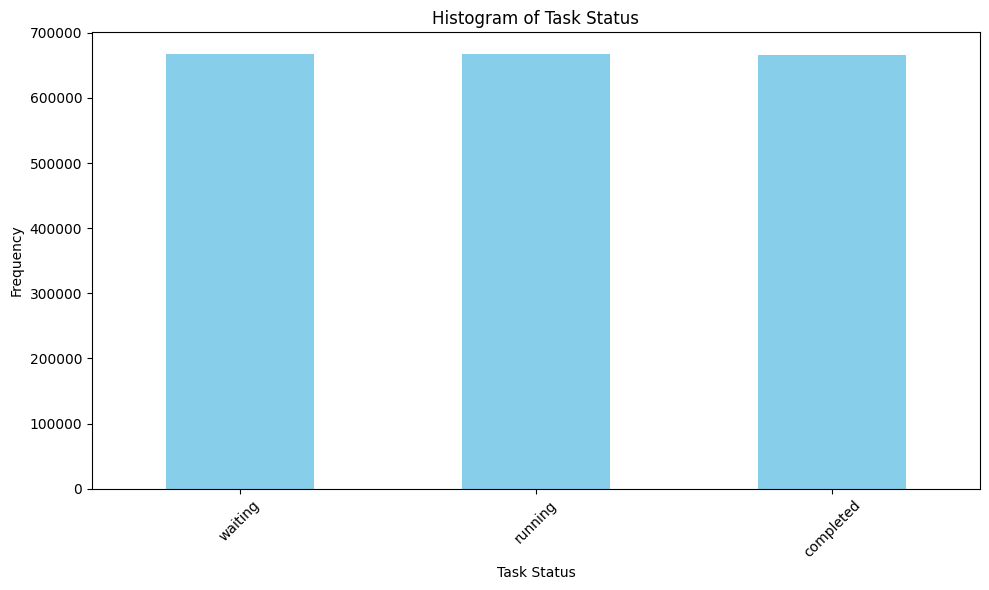

In [108]:
# Create a histogram for the 'task_status' column
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the histogram
df['task_status'].value_counts().plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Histogram of Task Status')
plt.xlabel('Task Status')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

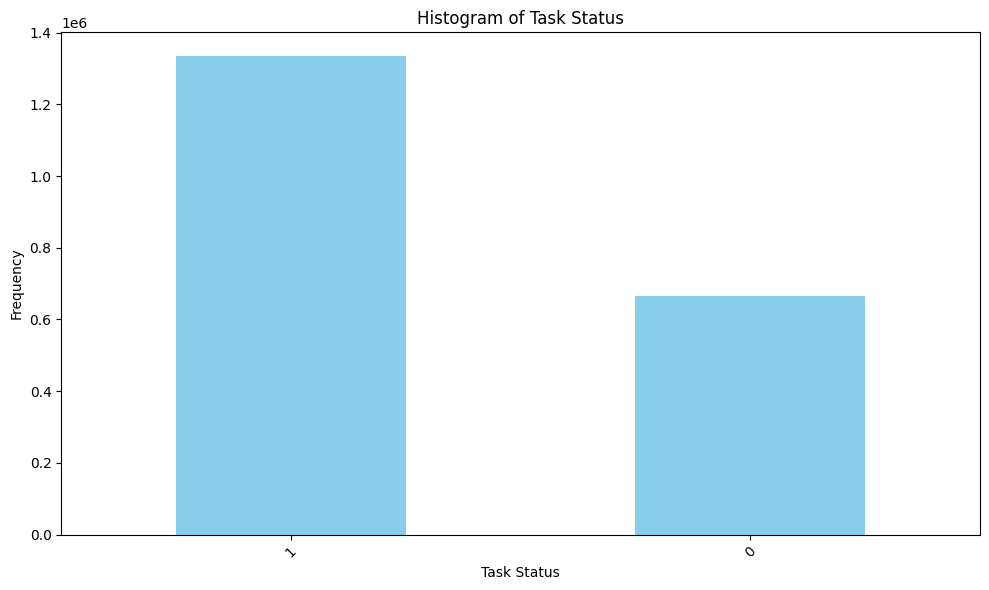

In [43]:
# Create a histogram for the 'task_status' column
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the histogram
cleaned_df['task_status'].value_counts().plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Histogram of Task Status')
plt.xlabel('Task Status')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [44]:
def preprocess_data(df, target='task_status'):
    # Separate features and target variable
    y = df[target]
    X = df.drop(columns=[target])
    
    # Create preprocessing pipeline
    numeric_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include='object').columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Train-test split first to prevent data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Apply preprocessing pipeline
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(cleaned_df)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [46]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary classification output layer
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Add callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True)  # Updated filepath format!
]

# Handle class imbalance (adjust weights based on class distribution)
class_weights = {0: 1., 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}

# Train the model
model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyError: 2

In [47]:
# Enhanced LSTM Model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model
# Train the model
model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
 
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 125s 6ms/step - accuracy: 0.6519 - loss: 0.6541 - precision: 0.6671 - recall: 0.9542 - val_accuracy: 0.6668 - val_loss: 0.6367 - val_precision: 0.6668 - val_recall: 1.0000
Epoch 2/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.6677 - loss: 0.6361 - precision: 0.6677 - recall: 1.0000 - val_accuracy: 0.6668 - val_loss: 0.6367 - val_precision: 0.6668 - val_recall: 1.0000
Epoch 3/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.6671 - loss: 0.6364 - precision: 0.6671 - recall: 1.0000 - val_accuracy: 0.6668 - val_loss: 0.6365 - val_precision: 0.6668 - val_recall: 1.0000
Epoch 4/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.6668 - loss: 0.6365 - precision: 0.6668 - recall: 1.0000 - val_accuracy: 0.6668 - val_loss: 0.6365 - val_precision: 0.6668 - val_recall: 1.0000
Epoch 5/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.6672 - loss: 0.6362 - precision: 0.6672 - recall: 1.0000 - 

In [48]:
# Predictions on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    133160
           1       0.67      1.00      0.80    266840

    accuracy                           0.67    400000
   macro avg       0.33      0.50      0.40    400000
weighted avg       0.45      0.67      0.53    400000


Confusion Matrix:
[[     0 133160]
 [     0 266840]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


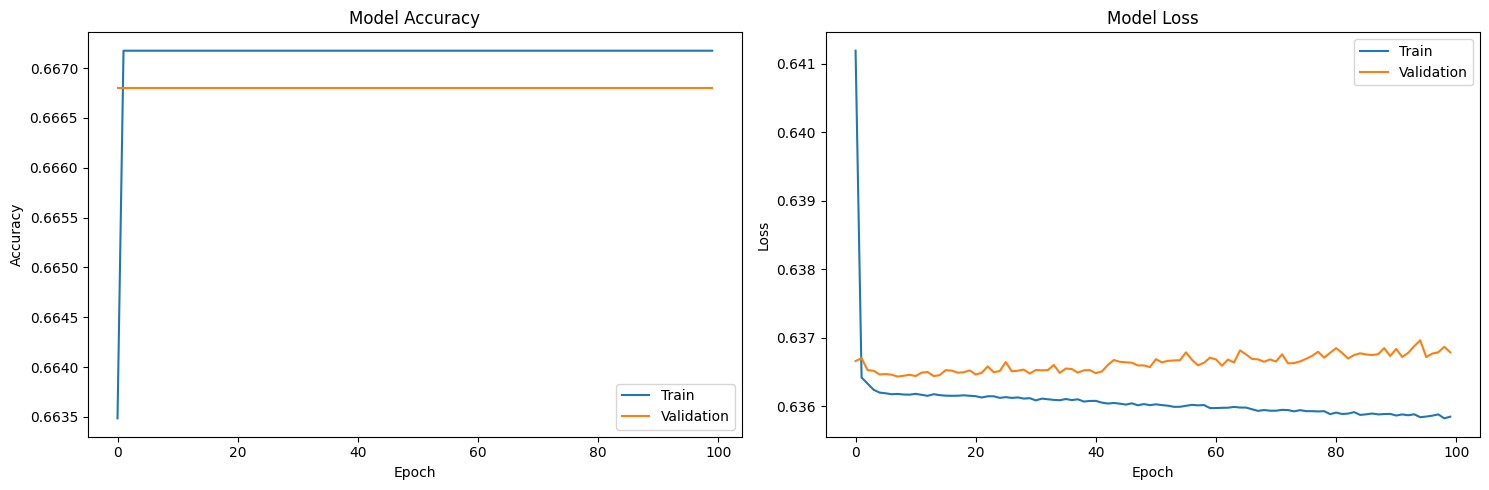

In [50]:
def plot_metrics():
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_metrics()
